In [1]:
# %%capture
# !pip install torch numpy pandas matplotlib scikit-learn

# !pip install git+https://github.com/gretelai/gretel-synthetics.git

  Using cached numpy-1.26.4-cp39-cp39-win_amd64.whl.metadata (61 kB)
  Using cached pandas-2.2.2-cp39-cp39-win_amd64.whl.metadata (19 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.2.1-cp39-cp39-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/165.0 kB ? eta -:--:--
     ------------------------------------- 165.0/165.0 kB 10.3 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp39-cp39-win_amd64.whl.metadata (6.5 kB)
  Using cached pillow-10.3.0-cp39-cp39-win_amd64.whl.metadata (9.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl.metadata (3.9 kB)
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ----------

  Running command git clone --filter=blob:none --quiet https://github.com/gretelai/gretel-synthetics.git 'C:\Users\lia68085\AppData\Local\Temp\pip-req-build-lmn7h_m9'


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
import os
import json
import torch
from pathlib import Path

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType



# Dataanalyse

In [80]:
# root=os.getcwd()
# parent_dir = os.path.dirname(root)
# parent_dir
# root=os.getcwd()
# datapath=os.path.join(parent_dir,'Dataanalyse\\axis2_demo_tablepart1_0.csv')
datapath=r'D:\studydata\Masterarbeit\Data\all_data_axis2.csv'
df=pd.read_csv(datapath)
df.drop_duplicates(subset=[df.columns[0]], inplace=True)

df.shape

(1445916, 30)

In [81]:
df.columns[0]

'ID'

In [82]:
1445916/10000

144.5916

In [83]:
import json
def getdata(path, length,interval):
    df=pd.read_csv(path)
    with open ('feature_important_axis2.json', 'r') as f:
        importance = json.load(f)[:10]
    importance=['Timestamp']+importance
    
    newdf=df[importance]
    newdf=newdf.copy()
    newdf['Timestamp'] = pd.to_datetime(newdf['Timestamp'], unit='s')
    difftiem=np.unique(newdf['Timestamp']) 
    data=[]
    for time in difftiem:
        length_of_data=len(newdf[newdf['Timestamp']==time])
        if length_of_data>length:
            slidedata=newdf[newdf['Timestamp']==time]
            slidedata=slidedata.copy()

            # slidedata['datetime'] = pd.date_range(start=slidedata['Timestamp'].iloc[0], periods=len(slidedata), freq=str(interval))
            # slidedata=slidedata.drop(columns=['Timestamp'], axis=1)

            data.append(slidedata)

    return data

In [84]:
data=getdata(datapath,2000,'S')

In [85]:
len(data)

143

In [68]:
data[2].head()

,Timestamp,Effektivwert_z,Median_z,Mittlere_Absolute_Abweichung_z,Mittelwert_z,Median_y,Effektivwert_y,Effektivwert_x,Variance_z,Mittelwert_x,Standardabweichung_z
33876,2021-01-14 18:46:40,15997.6,15872,387.435,15990.3,-512.0,436.928,378.066,234365.0,-206.080,483.871
33877,2021-01-14 18:46:40,16008.5,15872,411.140,16000.3,-512.0,444.143,351.662,262538.0,-187.136,512.128
33878,2021-01-14 18:46:40,16065.2,16128,409.663,16056.8,-512.0,455.795,377.285,269670.0,-211.968,519.037
33879,2021-01-14 18:46:40,16024.0,16128,404.933,16015.9,-512.0,445.984,365.283,260317.0,-178.176,509.958
33880,2021-01-14 18:46:40,16006.5,15872,403.629,15998.5,-512.0,452.041,376.329,258206.0,-192.768,507.885


In [86]:
    
def dataconcatente(listdata):
     
    two = np.empty((0, 2000, 10))

    for i, data in enumerate(listdata):

        sensor_df=data
        all_column = list(sensor_df.columns)
        all_column.remove('Timestamp')
        train_df=sensor_df
        train_df =pd.DataFrame(train_df)
        train_df = train_df.drop(columns="Timestamp").to_numpy()
        n = train_df.shape[0] // 2000
        train_df = train_df[:(n*2000),:].reshape(-1, 2000, train_df.shape[1])
        print(train_df.shape)
        two = np.concatenate((two, train_df), axis=0)
        print(two.shape)
        print('*'*20)
    return two

In [87]:
final=dataconcatente(data)
final.shape

(1, 2000, 10)
(1, 2000, 10)
********************
(1, 2000, 10)
(2, 2000, 10)
********************
(7, 2000, 10)
(9, 2000, 10)
********************
(8, 2000, 10)
(17, 2000, 10)
********************
(8, 2000, 10)
(25, 2000, 10)
********************
(8, 2000, 10)
(33, 2000, 10)
********************
(8, 2000, 10)
(41, 2000, 10)
********************
(6, 2000, 10)
(47, 2000, 10)
********************
(6, 2000, 10)
(53, 2000, 10)
********************
(8, 2000, 10)
(61, 2000, 10)
********************
(8, 2000, 10)
(69, 2000, 10)
********************
(8, 2000, 10)
(77, 2000, 10)
********************
(8, 2000, 10)
(85, 2000, 10)
********************
(8, 2000, 10)
(93, 2000, 10)
********************
(6, 2000, 10)
(99, 2000, 10)
********************
(8, 2000, 10)
(107, 2000, 10)
********************
(8, 2000, 10)
(115, 2000, 10)
********************
(8, 2000, 10)
(123, 2000, 10)
********************
(8, 2000, 10)
(131, 2000, 10)
********************
(8, 2000, 10)
(139, 2000, 10)
*******************

(625, 2000, 10)

In [58]:
# rootpath=os.getcwd()
# # go to the upper directory of rootpath
# rootpath=Path(rootpath).parents[0]
# #rootpath= './Thesis/Dataanalyse/'
# rootpath
# df=pd.read_csv(os.path.join(rootpath,'Dataanalyse/axis2_demo_tablepart1_0.csv'))
# with open (os.path.join(rootpath,'Dataanalyse/important_features.json'), 'r') as f:
#     features = json.load(f)[:10]
# features=['Timestamp']+features
# newdf=df[features]
# newdf=newdf.copy()
# newdf['Timestamp'] = pd.to_datetime(newdf['Timestamp'], unit='s')
# # create a new data column starting from the first timestamp, with a frequency of 1 second.
# newdf['datetime'] = pd.date_range(start=newdf['Timestamp'].iloc[0], periods=len(newdf), freq='S')
# newdf=newdf.drop(columns=['Timestamp'], axis=1)
# #change the last column to the first column
# cols = newdf.columns.tolist()   
# cols = cols[-1:] + cols[:-1]
# newdf=newdf[cols]
# newdf.head()
# newdf.to_csv('true_data.csv', index=False)

In [61]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import pandas as pd
# # fig,axs = plt.subplots(10,1,figsize=(10,2*10))

# # for i,j in enumerate(COLUMNS) :

# #     axs[i].plot(train_df["datetime"],train_df[j],label='GroundTruth')

# #     axs[i].legend()
# #     plt.ylabel("Temperature (Celsius)")
# #     plt.xlabel("Date")
# #     plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1000))  # 每10天显示一次日期
# #     plt.xticks(rotation=90)
# # plt.show()
# # # 假设 train_df 已经正确载入，并且 "datetime" 列已经转换为 datetime 类型
# fig, axs = plt.subplots(10, 1, figsize=(10, 20))  # 高度根据特征数量动态调整

# for i,j in enumerate(COLUMNS) :
#     # 如果只有一列，当只有一个特征时，axs不是列表，需要做一下处理
#     ax = axs[i] 
    
#     ax.plot(train_df[j], label='Actual')
#     ax.legend()
# plt.ylabel("Temperature (Celsius)")
# plt.xlabel("Date")
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1000))  # 每10天显示一次日期
# plt.xticks(rotation=90)
# plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
# plt.show()


In [58]:
x=list(data[0].columns)
x

['Timestamp',
 'Effektivwert_z',
 'Median_z',
 'Mittlere_Absolute_Abweichung_z',
 'Mittelwert_z',
 'Median_y',
 'Effektivwert_y',
 'Effektivwert_x',
 'Variance_z',
 'Mittelwert_x',
 'Standardabweichung_z']

In [15]:

feat = list(data[0].columns)
feat.remove('Timestamp')
# feat.remove('Variance_z')
# feat.remove('Effektivwert_x')

In [16]:
feat

['Effektivwert_z',
 'Median_z',
 'Mittlere_Absolute_Abweichung_z',
 'Mittelwert_z',
 'Median_y',
 'Effektivwert_y',
 'Effektivwert_x',
 'Variance_z',
 'Mittelwert_x',
 'Standardabweichung_z']

In [88]:
final[2,:,:].shape

(2000, 10)

In [89]:
df=pd.DataFrame(final[6,:,:])
df.head()

,0,1,2,3,4,5,6,7,8,9
0,15872.0,153.856,15895.9,15887.9,255069.0,336.131,321.563,504.791,266.077,403.630
1,15872.0,202.496,15923.0,15915.3,246428.0,356.291,313.045,496.167,258.459,401.036
2,15872.0,207.360,15908.7,15901.7,222032.0,351.756,328.629,470.967,269.926,383.349
3,15872.0,155.392,15934.6,15927.0,240940.0,346.689,312.965,490.611,258.342,395.023
4,15872.0,186.112,15887.2,15880.2,223897.0,332.307,327.087,472.941,264.504,376.324


In [ ]:
# # Show a few of the 1-day training samples

# xaxis_1day = data[0]["datetime"][:60]
# len(xaxis_1day)
# feat = list(data[0].columns)


def plot_day(f):
    df_sample = pd.DataFrame(f, columns=feat)
    # df_sample.drop(columns=['Variance_z','Effektivwert_z','Mittelwert_z','Median_z'], inplace=True)
    print(df_sample.columns)
    for i, c in enumerate(df_sample.columns):
        print(i,c)
        plt.plot(range(len(df_sample)), df_sample[c], label=c)
    # ax = plt.gca()
    # ax.xaxis.set_major_locator(md.HourLocator(byhour=range(2,24,3)))
    # ax.xaxis.set_major_formatter(md.DateFormatter("%H:%M"))
    # plt.gca().xaxis.set_major_locator(md.DayLocator(interval=int(len(xaxis_1day)/10)))  # 每10天显示一次日期

    plt.legend()
    plt.xlabel("Time")
    plt.xticks(rotation=90)

    plt.ylabel("Temperature (Celsius)")
    plt.show()

plot_day(final[6,:,:])
plot_day(final[8,:,:])
# plot_day(features[21,:,:])

In [90]:
final.shape

(625, 2000, 10)

In [91]:
max_sequence_len=final.shape[1]
max_sequence_len

2000

In [30]:
import time

# Train DGAN model
model = DGAN(DGANConfig(
    max_sequence_len=final.shape[1],
    sample_len=1000,
    batch_size=32,
    apply_feature_scaling=True,
    apply_example_scaling=True,
    use_attribute_discriminator=True,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=250,
))

model.train_numpy(
    final,
    feature_types=[OutputType.CONTINUOUS] * final.shape[2],
)

# Save the trained model
model.save('dgan_model_10000_axis2.pkl')
_,synthetic_features = model.generate_numpy(30)
synthetic_features=np.array(synthetic_features)
import pickle
with open('synthetic_data_10000_axis2.pkl', 'wb') as f:
    pickle.dump(synthetic_features, f)

In [92]:
final.shape

(625, 2000, 10)

In [93]:
import pickle
# Load the synthetic data
with open('synthetic_data_2000_axis2.pkl', 'rb') as f:
    synthetic_features = pickle.load(f)
synthetic_features.shape

(200, 2000, 10)

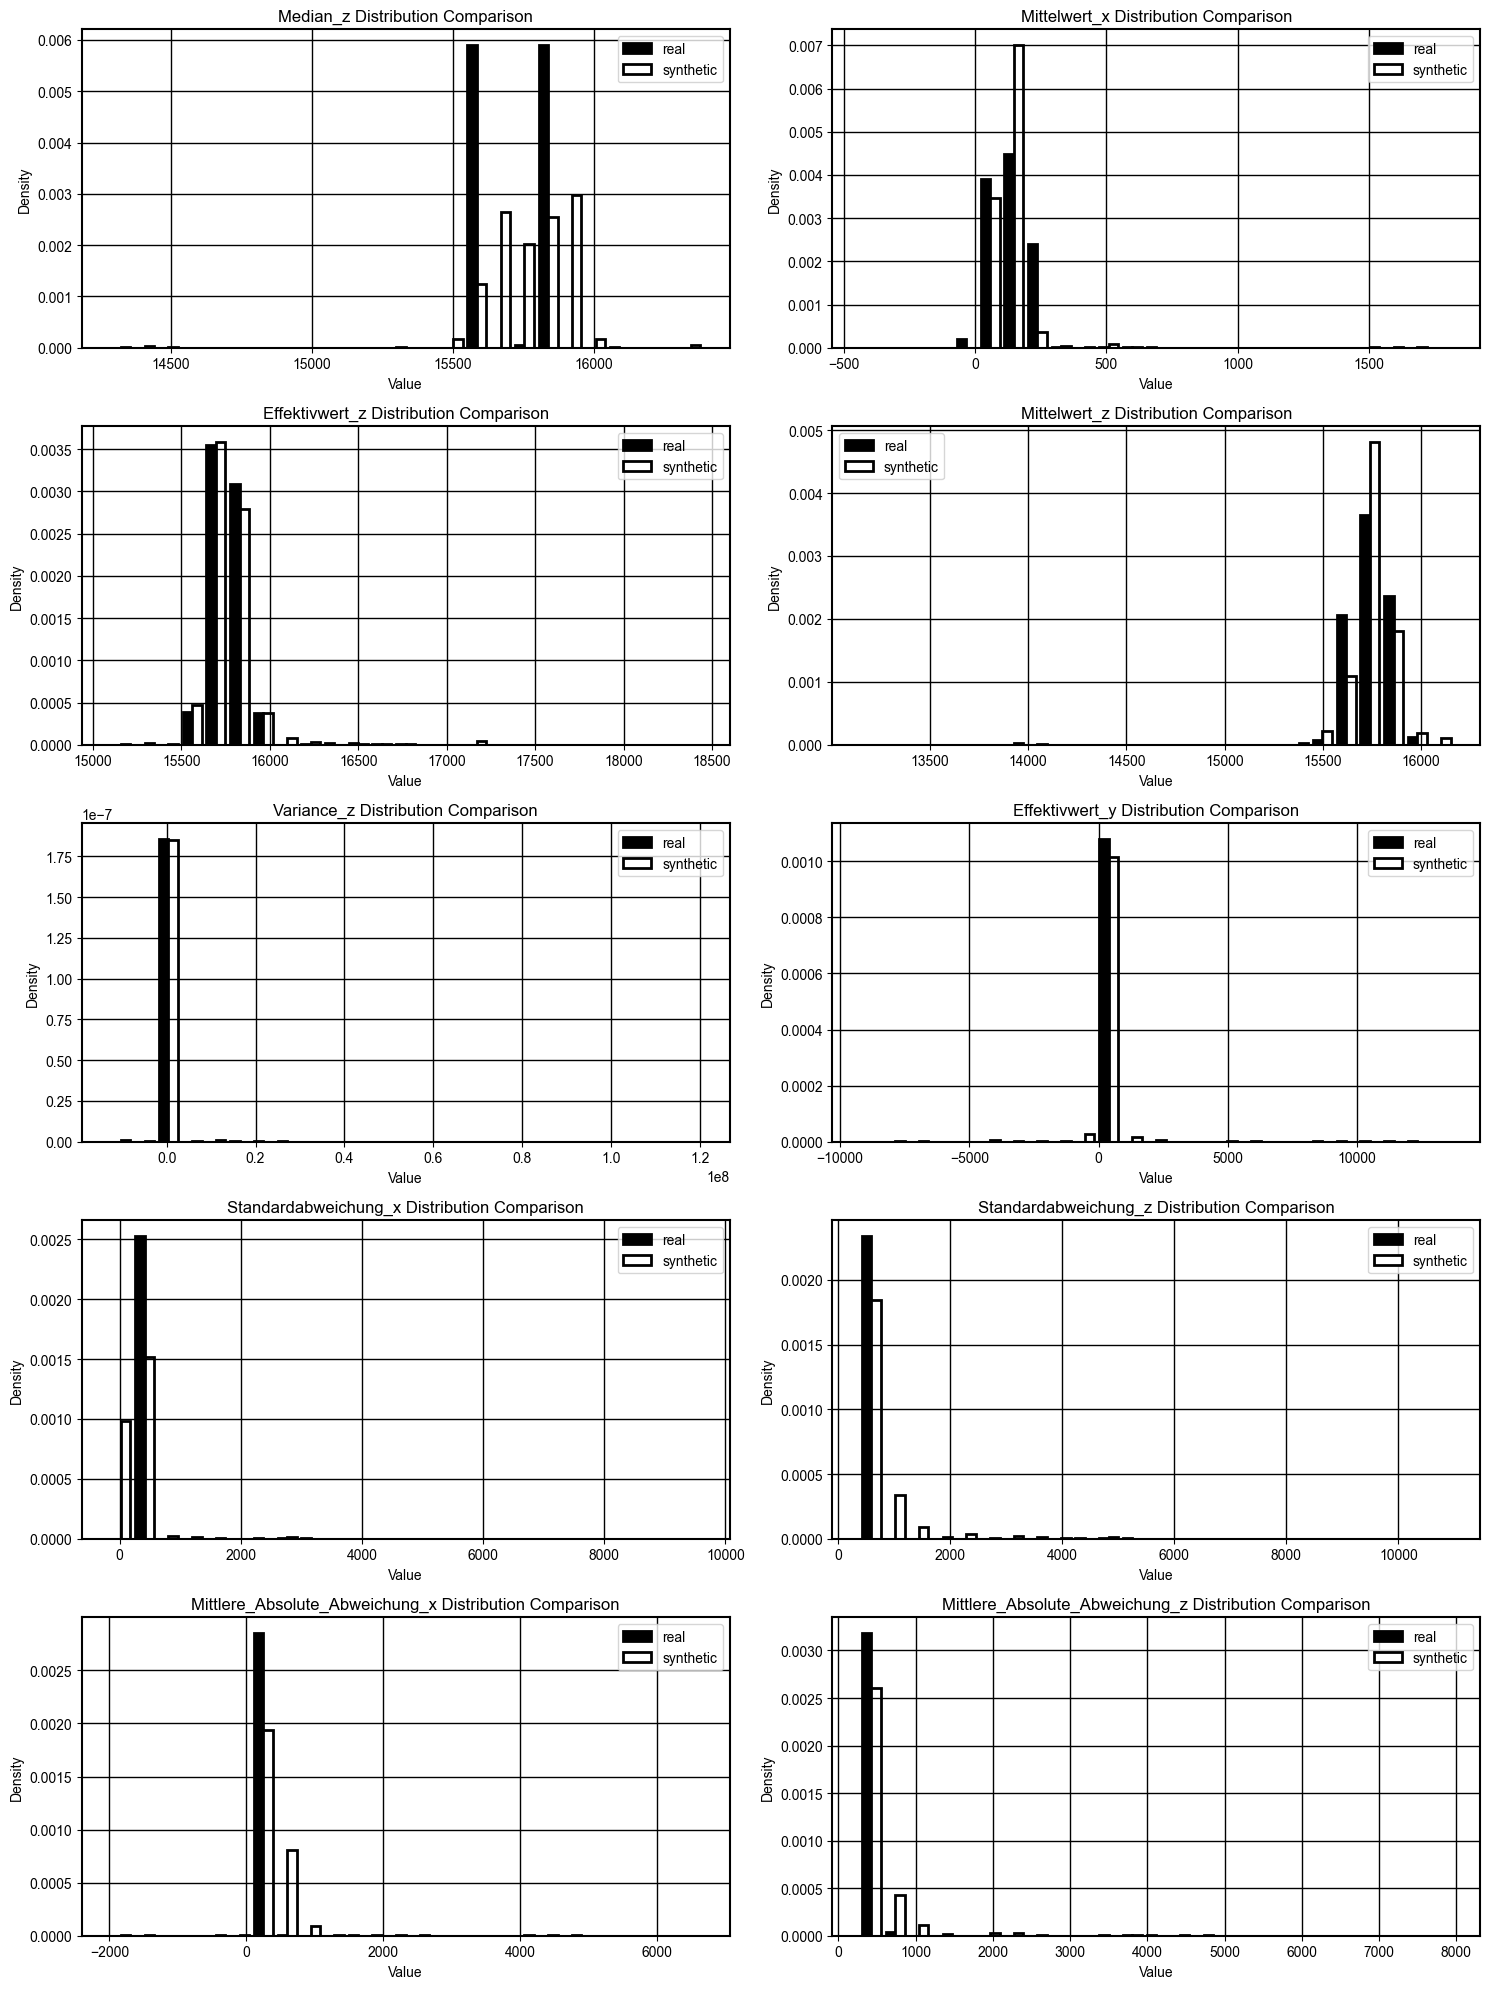

<Figure size 640x480 with 0 Axes>

In [94]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 final 和 synthetic_features 的形状分别为 (300, 2000, 10)
final = final
synthetic_features = synthetic_features

# 假设 columns 包含特征的名字
columns=data[2].columns[1:]
columns
# 特征数量
num_features = synthetic_features.shape[-1]
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
# 创建多列子图
# # 定义颜色
# color1 = (159/255, 182/255, 196/255)  # R:159, G:182, B:196
# color2 = (153/255, 0/255, 0/255)      # R:153, G:0, B:0

n_cols = 2  # 列数
n_rows = (num_features + n_cols - 1) // n_cols  # 行数

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

# 比较每个特征的分布
for i in range(num_features):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]


    ax.hist([final[:,:,i].flatten(), synthetic_features[:,:,i].flatten()], 
            label=["real", "synthetic"],
            bins=25,
            density=True,
            edgecolor='black',
            linewidth=2,
            color=['black', 'white']
            )
    ax.legend()
    ax.grid(True, linewidth=1.0, color='black')  # 网格线宽为1pt

    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.set_title(f"{columns[i]} Distribution Comparison")
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)

# 移除多余的子图
for i in range(num_features, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

# 调整子图布局
plt.tight_layout()
plt.show()
plt.savefig('distribution_comparison_axis2_2000.jpg')

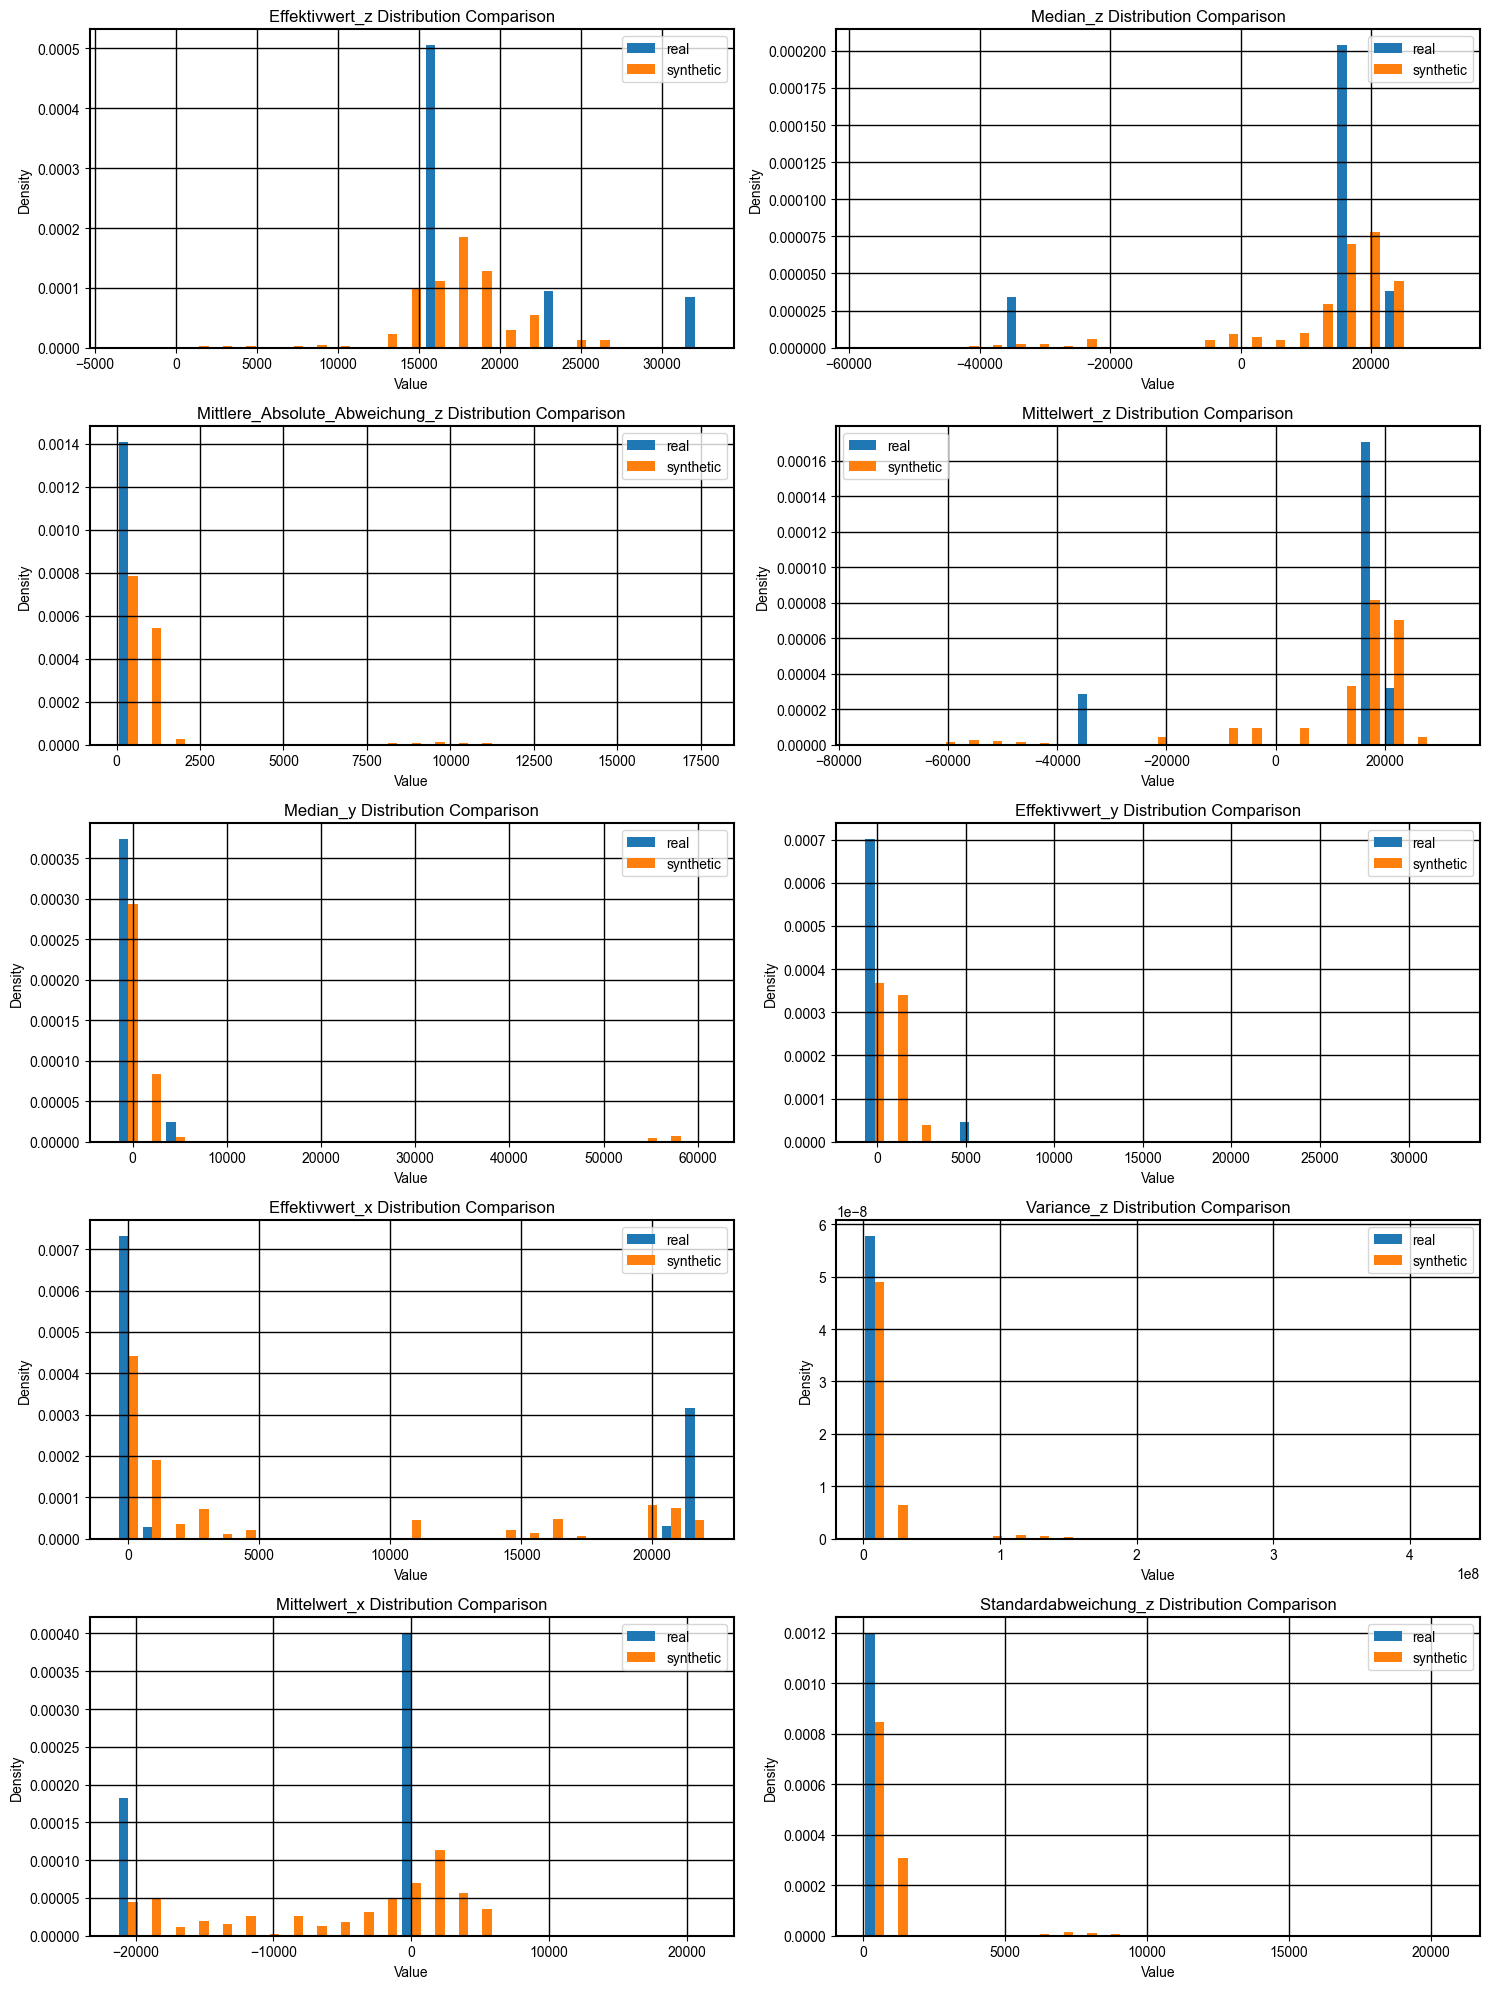

<Figure size 640x480 with 0 Axes>

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 final 和 synthetic_features 的形状分别为 (300, 2000, 10)
final = final
synthetic_features = synthetic_features

# 假设 columns 包含特征的名字
columns=data[2].columns[1:]
columns
# 特征数量
num_features = synthetic_features.shape[-1]
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
# 创建多列子图
# # 定义颜色
# color1 = (159/255, 182/255, 196/255)  # R:159, G:182, B:196
# color2 = (153/255, 0/255, 0/255)      # R:153, G:0, B:0

n_cols = 2  # 列数
n_rows = (num_features + n_cols - 1) // n_cols  # 行数

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

# 比较每个特征的分布
for i in range(num_features):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]




    ax.hist([final[:,:,i].flatten(), synthetic_features[:,:,i].flatten()], 
            label=["real", "synthetic"],
            bins=25,
            density=True,

            )

    ax.legend()
    ax.grid(True, linewidth=1.0, color='black')  # 网格线宽为1pt

    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.set_title(f"{columns[i]} Distribution Comparison")
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)

# 移除多余的子图
for i in range(num_features, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

# 调整子图布局
plt.tight_layout()
plt.show()
plt.savefig('distribution_comparison_axis1_10000.jpg')

In [ ]:
# import time

# # Train DGAN model
# model = DGAN(DGANConfig(
#     max_sequence_len=final.shape[1],
#     sample_len=200,
#     batch_size=32,
#     apply_feature_scaling=True,
#     apply_example_scaling=True,
#     use_attribute_discriminator=True,
#     generator_learning_rate=1e-4,
#     discriminator_learning_rate=1e-4,
#     epochs=250,
# ))
# start_time = time.time()

# model.train_numpy(
#     final,
#     feature_types=[OutputType.CONTINUOUS] * final.shape[2],
# )

# # Generate synthetic data
# end_time = time.time()
# epoch_time = end_time - start_time
# print(f"Epoch {1} training time: {epoch_time:.2f} seconds")
# # Save the trained model
# model.save('dgan_model_2000_axis2.pkl')
# _,synthetic_features = model.generate_numpy(300)
# synthetic_features=np.array(synthetic_features)
# import pickle
# with open('synthetic_data_2000_axis1.pkl', 'wb') as f:
#     pickle.dump(synthetic_features, f)

In [80]:
_,synthetic_features = model.generate_numpy(300)


NameError: name 'model' is not defined

In [7]:
final=synthetic_features[:400]
final.shape

(400, 2000, 10)

In [1]:
import pickle
# Load the synthetic data
with open('synthetic_data_10000_axis1.pkl', 'rb') as f:
    synthetic_features = pickle.load(f)
synthetic_features.shape

In [2]:
synthetic_features.shape

(50, 10000, 10)

Index(['Effektivwert_z', 'Median_z', 'Mittlere_Absolute_Abweichung_z',
       'Mittelwert_z', 'Median_y', 'Effektivwert_y', 'Effektivwert_x',
       'Variance_z', 'Mittelwert_x', 'Standardabweichung_z'],
      dtype='object')
0 Effektivwert_z
1 Median_z
2 Mittlere_Absolute_Abweichung_z
3 Mittelwert_z
4 Median_y
5 Effektivwert_y
6 Effektivwert_x
7 Variance_z
8 Mittelwert_x
9 Standardabweichung_z


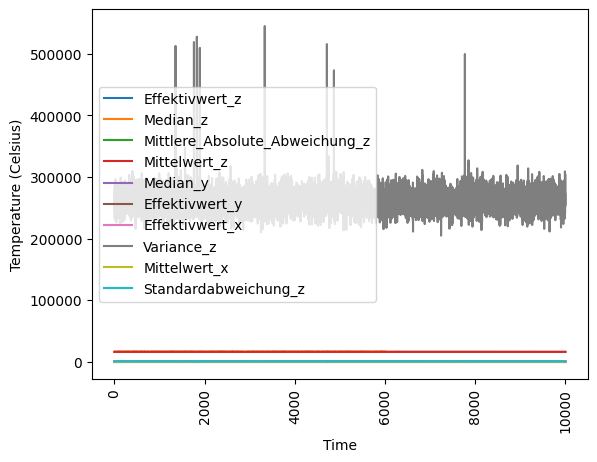

Index(['Effektivwert_z', 'Median_z', 'Mittlere_Absolute_Abweichung_z',
       'Mittelwert_z', 'Median_y', 'Effektivwert_y', 'Effektivwert_x',
       'Variance_z', 'Mittelwert_x', 'Standardabweichung_z'],
      dtype='object')
0 Effektivwert_z
1 Median_z
2 Mittlere_Absolute_Abweichung_z
3 Mittelwert_z
4 Median_y
5 Effektivwert_y
6 Effektivwert_x
7 Variance_z
8 Mittelwert_x
9 Standardabweichung_z


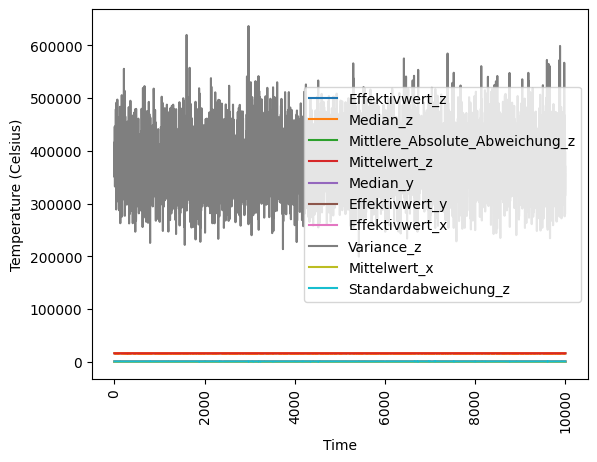

Index(['Effektivwert_z', 'Median_z', 'Mittlere_Absolute_Abweichung_z',
       'Mittelwert_z', 'Median_y', 'Effektivwert_y', 'Effektivwert_x',
       'Variance_z', 'Mittelwert_x', 'Standardabweichung_z'],
      dtype='object')
0 Effektivwert_z
1 Median_z
2 Mittlere_Absolute_Abweichung_z
3 Mittelwert_z
4 Median_y
5 Effektivwert_y
6 Effektivwert_x
7 Variance_z
8 Mittelwert_x
9 Standardabweichung_z


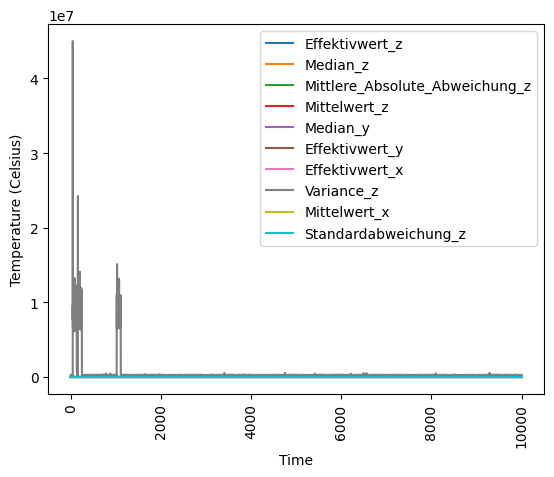

In [52]:
plot_day(final[2,:,:])
plot_day(final[45,:,:])
plot_day(final[6,:,:])

Index(['Effektivwert_z', 'Median_z', 'Mittlere_Absolute_Abweichung_z',
       'Mittelwert_z', 'Median_y', 'Effektivwert_y', 'Effektivwert_x',
       'Variance_z', 'Mittelwert_x', 'Standardabweichung_z'],
      dtype='object')
0 Effektivwert_z
1 Median_z
2 Mittlere_Absolute_Abweichung_z
3 Mittelwert_z
4 Median_y
5 Effektivwert_y
6 Effektivwert_x
7 Variance_z
8 Mittelwert_x
9 Standardabweichung_z


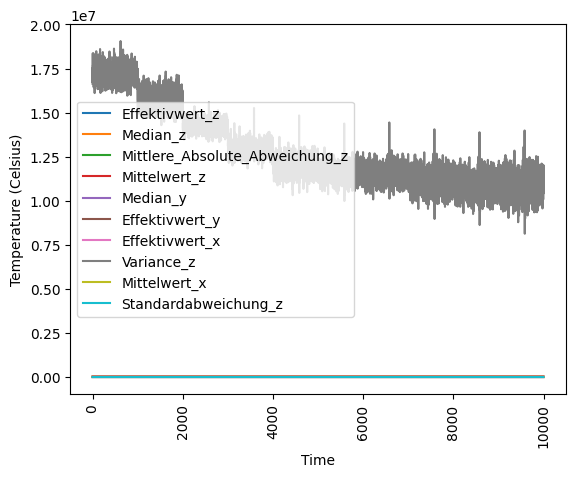

Index(['Effektivwert_z', 'Median_z', 'Mittlere_Absolute_Abweichung_z',
       'Mittelwert_z', 'Median_y', 'Effektivwert_y', 'Effektivwert_x',
       'Variance_z', 'Mittelwert_x', 'Standardabweichung_z'],
      dtype='object')
0 Effektivwert_z
1 Median_z
2 Mittlere_Absolute_Abweichung_z
3 Mittelwert_z
4 Median_y
5 Effektivwert_y
6 Effektivwert_x
7 Variance_z
8 Mittelwert_x
9 Standardabweichung_z


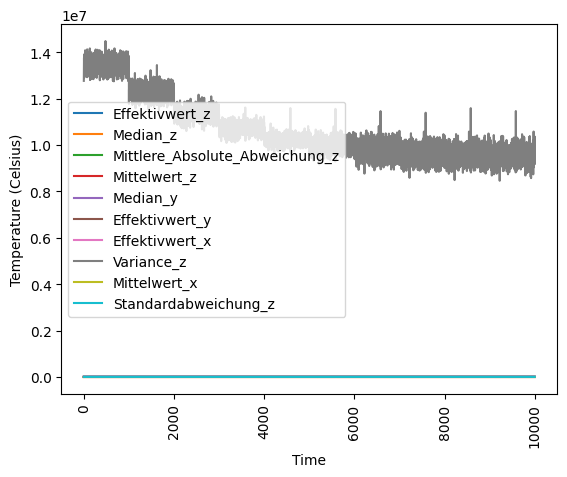

Index(['Effektivwert_z', 'Median_z', 'Mittlere_Absolute_Abweichung_z',
       'Mittelwert_z', 'Median_y', 'Effektivwert_y', 'Effektivwert_x',
       'Variance_z', 'Mittelwert_x', 'Standardabweichung_z'],
      dtype='object')
0 Effektivwert_z
1 Median_z
2 Mittlere_Absolute_Abweichung_z
3 Mittelwert_z
4 Median_y
5 Effektivwert_y
6 Effektivwert_x
7 Variance_z
8 Mittelwert_x
9 Standardabweichung_z


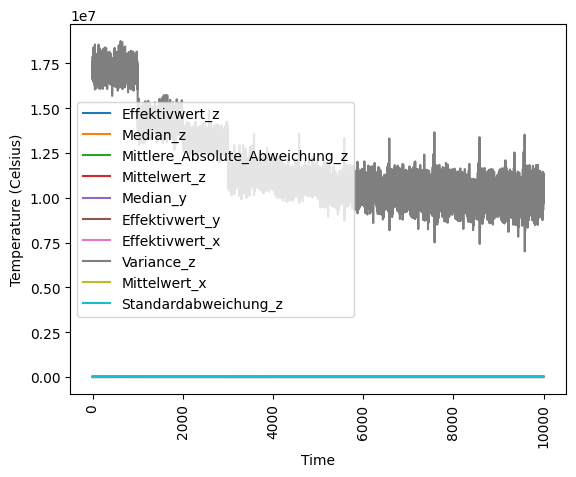

In [53]:
# Show some synthetic 1-day samples


plot_day(synthetic_features[2,:,:])
plot_day(synthetic_features[45,:,:])
plot_day(synthetic_features[6,:,:])

# Overall trends are similar to training samples, but with more local noise

In [27]:
test=pd.DataFrame(synthetic_features[6,:,:])
test.head()

,0,1,2,3,4,5,6,7,8,9
0,15853.505859,15508.460938,674.619141,15838.953125,377.775146,1108.741211,609.356567,16689175.0,-1923.042969,764.619263
1,15817.940430,15523.996094,640.977966,15796.214844,359.944214,1138.864380,612.321960,17590600.0,-1936.318359,707.961426
2,15846.983398,15518.968750,624.609802,15864.218750,284.948608,1166.466919,593.741577,17167542.0,-1848.652344,821.952698
3,15837.776367,15664.949219,642.095276,15804.078125,421.973511,1175.509888,579.327148,16573779.0,-1897.716797,754.180847
4,15853.436523,15669.500000,661.867859,16011.746094,364.554321,1247.282715,612.293701,17898980.0,-1909.509766,721.860657


In [30]:
synthetic_features.shape

(200, 2000, 10)

In [31]:
data[2].columns

Index(['Timestamp', 'Median_z', 'Mittelwert_x', 'Effektivwert_z',
       'Mittelwert_z', 'Variance_z', 'Effektivwert_y', 'Standardabweichung_x',
       'Standardabweichung_z', 'Mittlere_Absolute_Abweichung_x',
       'Mittlere_Absolute_Abweichung_z'],
      dtype='object')

In [18]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta


# 获取当前时间
current_time = datetime.now()

# 生成UNIX时间戳列表，每个批次的时间戳相差一小时
timestamps = [(current_time + timedelta(hours=i)).timestamp() for i in range(synthetic_features.shape[0])]

# 为每个批次添加UNIX时间戳
# 扩展时间戳的形状，使其与 synthetic_features 匹配
timestamp_array = np.array(timestamps).reshape(-1, 1, 1)
timestamp_array = np.tile(timestamp_array, (1, synthetic_features.shape[1], 1))

# 合并时间戳和特征数据
synthetic_features_with_timestamps = np.concatenate((timestamp_array, synthetic_features), axis=2)

# 将三维数组转换为二维数据框
reshaped_features = synthetic_features_with_timestamps.reshape(-1, synthetic_features_with_timestamps.shape[2])

# 假设原始数据框的列名如下
columns =data[2].columns

# 创建数据框
synthetic_df = pd.DataFrame(reshaped_features, columns=columns)

# 打印数据框
print(synthetic_df)


           Timestamp  Standardabweichung_y  Variance_z   Variance_y  \
0       1.719248e+09            130.935013   7859338.0  1810773.125   
1       1.719248e+09            118.983566   8334222.5  1723374.750   
2       1.719248e+09            132.156174   8512899.0  1736353.500   
3       1.719248e+09            131.691650   7823354.5  1656044.000   
4       1.719248e+09            123.778328   8527875.0  1656661.625   
...              ...                   ...         ...          ...   
999995  1.721044e+09            469.303680   6424724.0  2319296.750   
999996  1.721044e+09            455.236115   6412121.5  2011810.000   
999997  1.721044e+09            461.012512   6242599.5  2245985.750   
999998  1.721044e+09            485.138947   6067121.5  2157200.000   
999999  1.721044e+09            450.344971   6015742.5  2150325.750   

        Standardabweichung_z  Effektivwert_x  Mittlere_Absolute_Abweichung_y  \
0                1079.481567      493.794006                      2

In [19]:
#synthetic_df.to_csv('synthetic_data_all.csv', index=False)

In [30]:
synthetic_df = pd.DataFrame(synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=data[2].columns[1:])
synthetic_df

,Effektivwert_z,Median_z,Mittlere_Absolute_Abweichung_z,Mittelwert_z,Median_y,Effektivwert_y,Effektivwert_x,Variance_z,Mittelwert_x,Standardabweichung_z
0,13939.009766,21030.402344,1308.211670,17277.109375,1010.787109,1276.927734,20346.619141,12328100.0,-16969.375000,886.312500
1,13862.076172,21020.027344,1321.467651,17220.421875,907.935303,1219.153564,20392.701172,13458755.0,-16939.951172,923.019409
2,13894.307617,21022.558594,1285.380859,17250.023438,1010.308350,1301.046997,20378.734375,13134255.0,-16945.289062,945.231873
3,13878.738281,21337.906250,1313.531128,17277.574219,1080.265869,1211.750610,20349.361328,12526677.0,-16908.394531,868.712158
4,13915.550781,21118.734375,1325.578247,17304.449219,1199.155273,1410.306274,20381.224609,13421669.0,-16913.527344,850.431152
...,...,...,...,...,...,...,...,...,...,...
499995,21858.548828,4632.273438,255.979080,4670.085938,-689.962341,1073.596802,400.452728,6360842.5,945.587891,328.705811
499996,21860.375000,4580.570312,298.571411,4614.785156,-717.921326,1039.573364,416.409576,6949232.0,936.277344,405.386597
499997,21834.052734,4578.906250,277.177673,4540.761719,-734.195374,1016.322021,427.939819,6962788.0,940.738281,288.685394
499998,21882.958984,4475.980469,299.355286,4516.101562,-654.090271,1021.138794,427.195862,6690855.0,957.644531,322.448334


In [22]:
# Compare (non-temporal) correlations between the 4 temperatures
synthetic_df = pd.DataFrame(synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=data[2].columns[1:])

print("Correlation in real data:")
print(data[2].corr())
print()
print("Correlation in synthetic data:")
print(synthetic_df.corr())

# Correlations between temperature variables are similar

Correlation in real data:
                                Effektivwert_z  Median_z  \
Effektivwert_z                        1.000000  0.748348   
Median_z                              0.748348  1.000000   
Mittlere_Absolute_Abweichung_z       -0.050083 -0.031310   
Mittelwert_z                          0.999868  0.748405   
Median_y                              0.034868  0.013423   
Effektivwert_y                        0.122729  0.126356   
Effektivwert_x                        0.059467  0.052827   
Variance_z                            0.170359  0.118813   
Mittelwert_x                         -0.093053 -0.023206   
Standardabweichung_z                  0.171715  0.120599   

                                Mittlere_Absolute_Abweichung_z  Mittelwert_z  \
Effektivwert_z                                       -0.050083      0.999868   
Median_z                                             -0.031310      0.748405   
Mittlere_Absolute_Abweichung_z                        1.000000     -0.064

C:\Users\28968\AppData\Local\Temp\ipykernel_22112\1236717808.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(data[2].corr())


In [91]:
final.shape

(1131, 2000, 10)

In [31]:
synthetic_features.shape

(50, 10000, 10)

In [32]:
columns=data[2].columns[1:]
columns

Index(['Effektivwert_z', 'Median_z', 'Mittlere_Absolute_Abweichung_z',
       'Mittelwert_z', 'Median_y', 'Effektivwert_y', 'Effektivwert_x',
       'Variance_z', 'Mittelwert_x', 'Standardabweichung_z'],
      dtype='object')

In [33]:
final.shape

(158, 10000, 10)

In [35]:
synthetic_features.shape

(50, 10000, 10)

In [29]:
columns=data[2].columns[1:]
columns

Index(['Median_z', 'Mittelwert_x', 'Effektivwert_z', 'Mittelwert_z',
       'Variance_z', 'Effektivwert_y', 'Standardabweichung_x',
       'Standardabweichung_z', 'Mittlere_Absolute_Abweichung_x',
       'Mittlere_Absolute_Abweichung_z'],
      dtype='object')

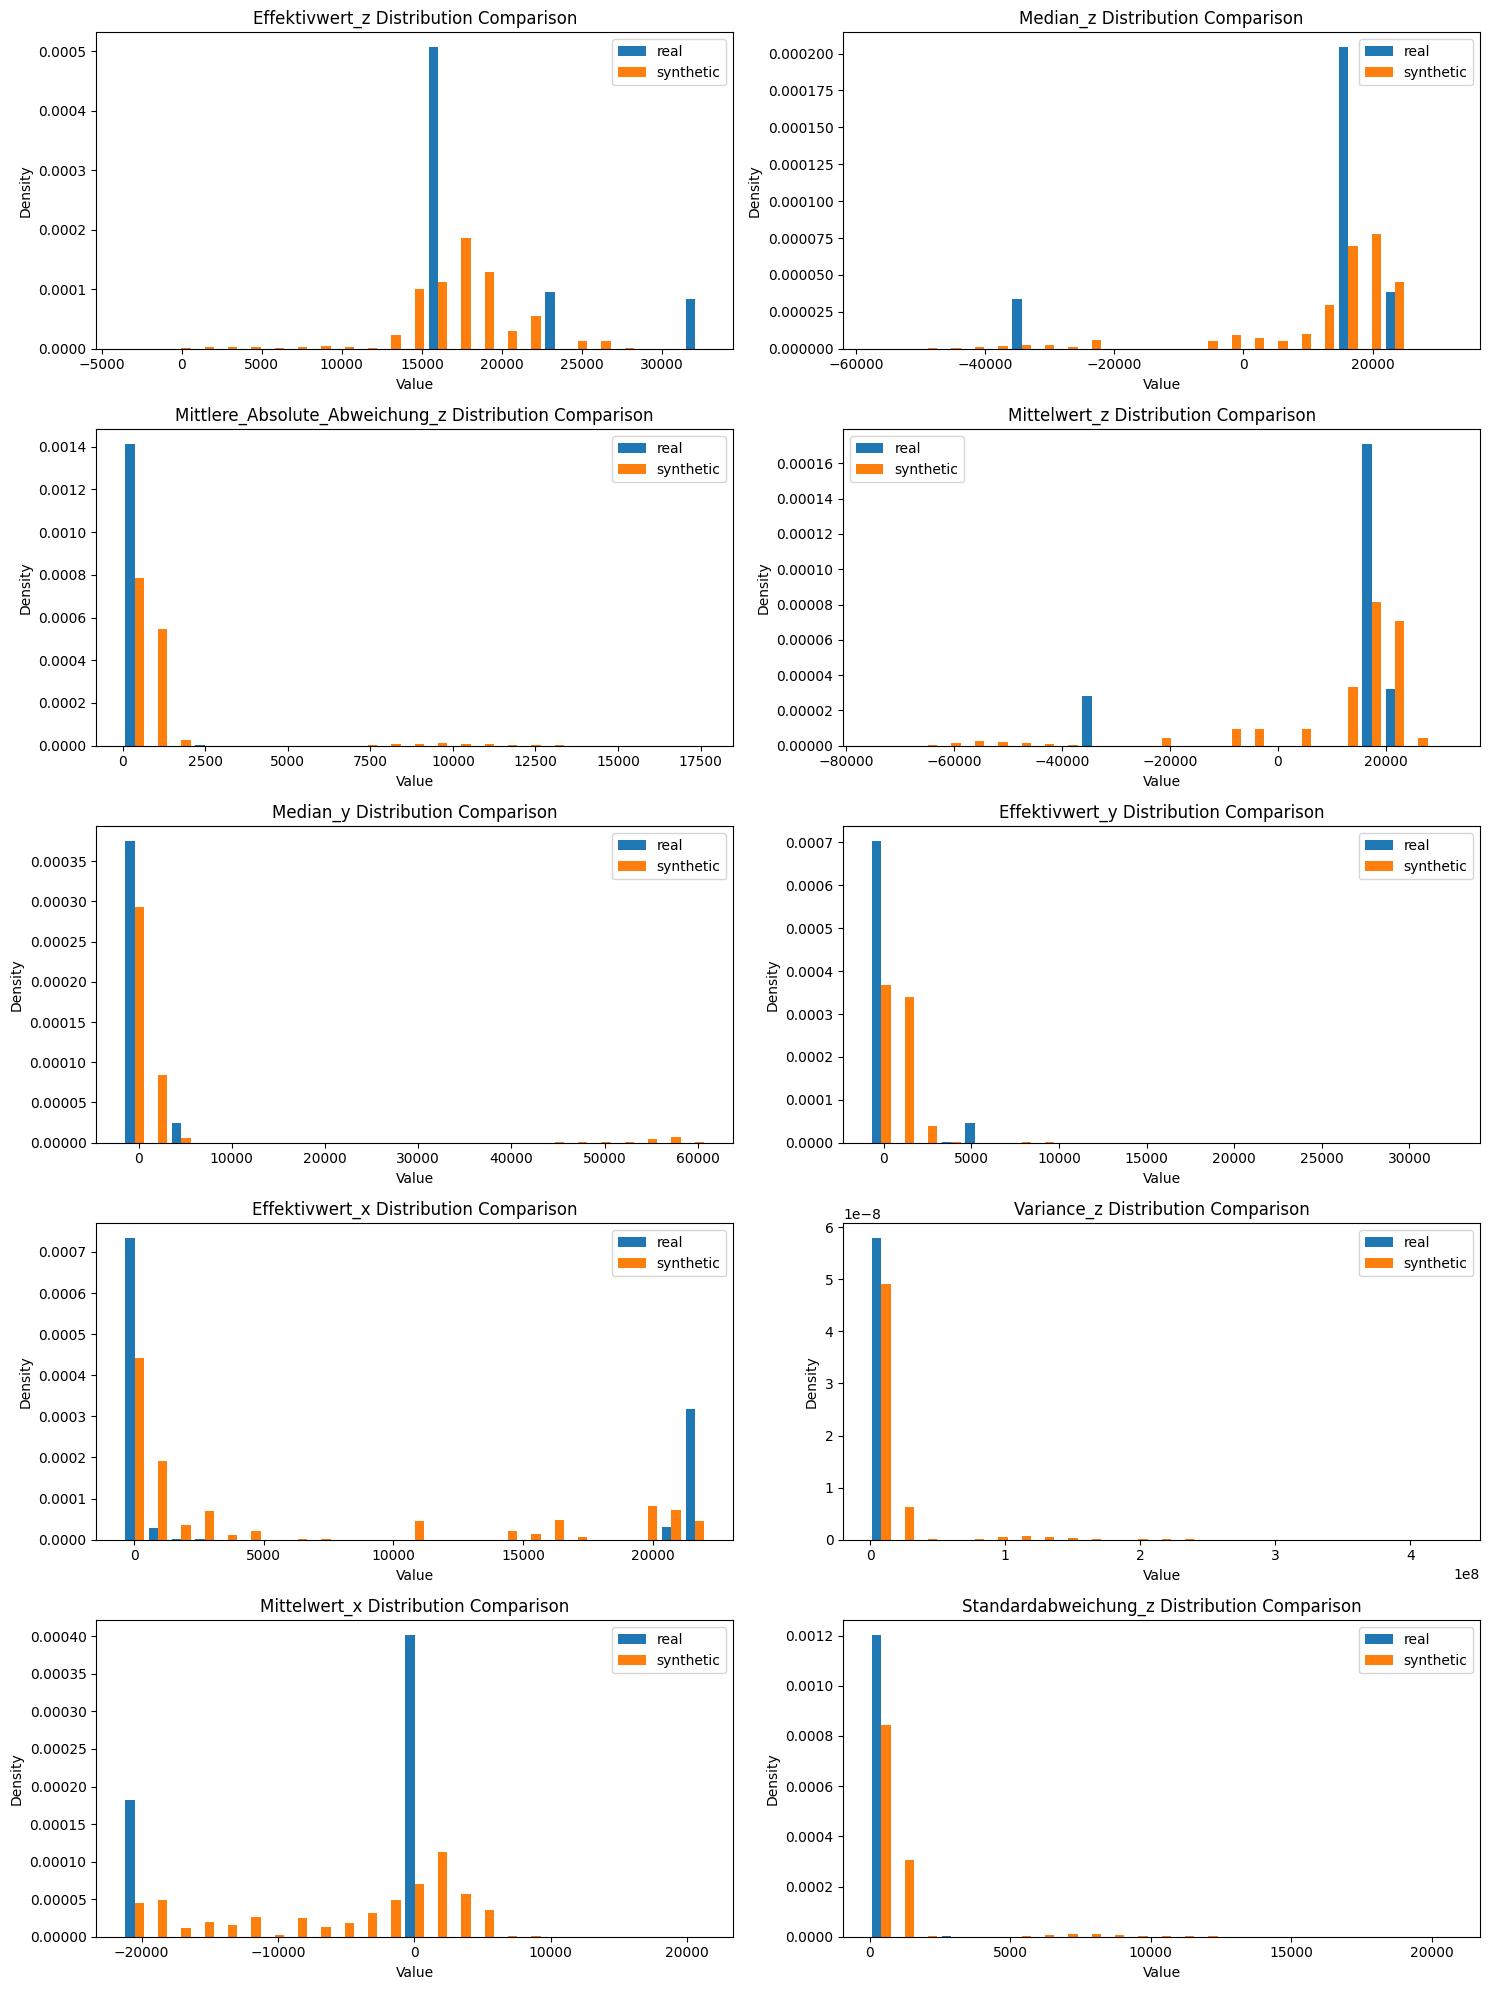

<Figure size 640x480 with 0 Axes>

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 final 和 synthetic_features 的形状分别为 (300, 2000, 10)
final = final
synthetic_features = synthetic_features

# 假设 columns 包含特征的名字
columns=data[2].columns[1:]
columns
# 特征数量
num_features = synthetic_features.shape[-1]

# 创建多列子图
n_cols = 2  # 列数
n_rows = (num_features + n_cols - 1) // n_cols  # 行数

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

# 比较每个特征的分布
for i in range(num_features):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.hist([final[:,:,i].flatten(), synthetic_features[:,:,i].flatten()], 
            label=["real", "synthetic"],
            bins=25,
            density=True)
    ax.legend()
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.set_title(f"{columns[i]} Distribution Comparison")

# 移除多余的子图
for i in range(num_features, n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

# 调整子图布局
plt.tight_layout()
plt.show()
plt.savefig('distribution_comparison_axis2_10000.jpg')

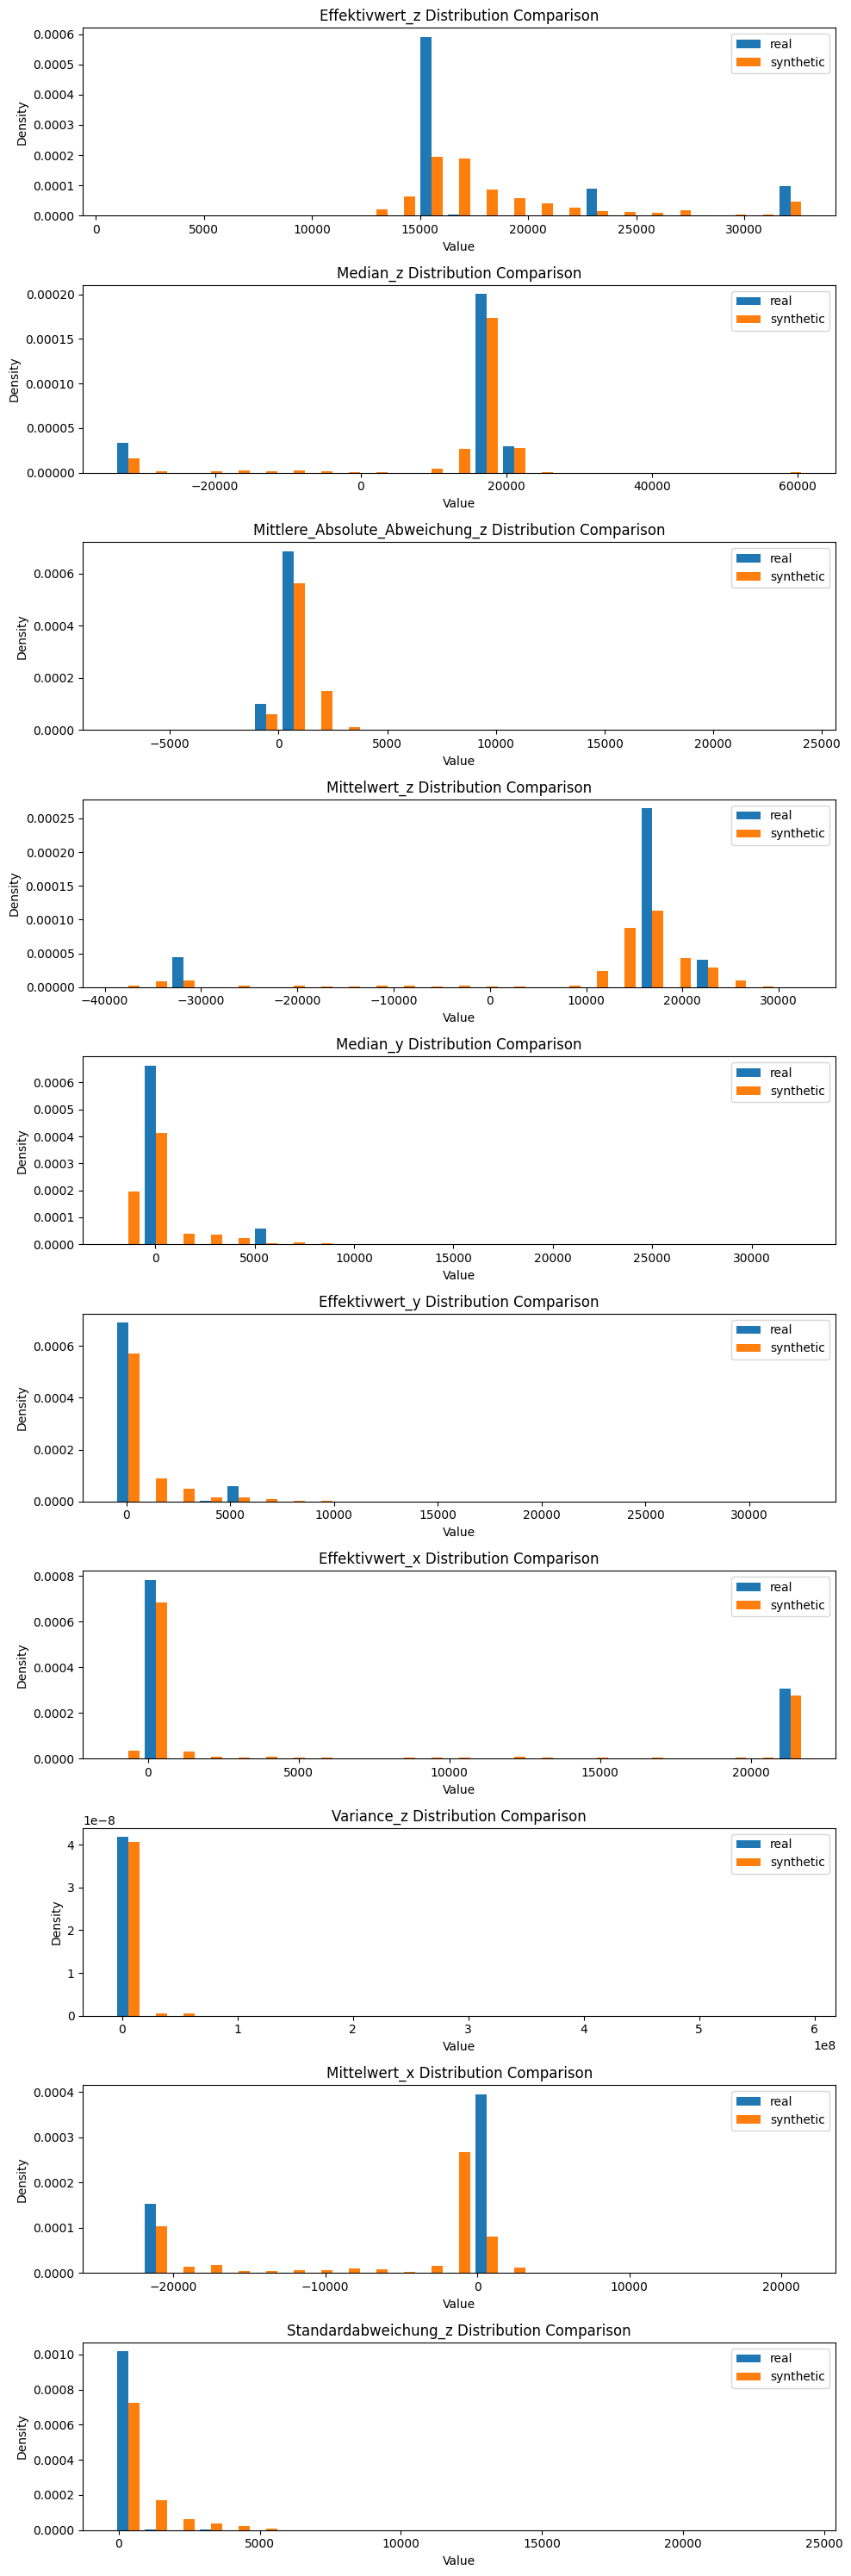

<Figure size 640x480 with 0 Axes>

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 final 和 synthetic_features 的形状分别为 (300, 2000, 10)
final = final
synthetic_features = synthetic_features
# 特征数量
num_features = synthetic_features.shape[-1]
columns=data[2].columns[1:]
columns
# 创建子图
fig, axes = plt.subplots(num_features, 1, figsize=(10, num_features * 3))

# 比较每个特征的分布
for i in range(num_features):
    ax = axes[i]
    ax.hist([final[:,:,i].flatten(), synthetic_features[:,:,i].flatten()], 
            label=["real", "synthetic"],
            bins=25,
            density=True)
    ax.legend()
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    ax.set_title(f"{columns[i]} Distribution Comparison")

# 调整子图布局
plt.tight_layout()
plt.show()
# save the plot 
plt.savefig('distribution_comparison_axis1_2000.jpg')

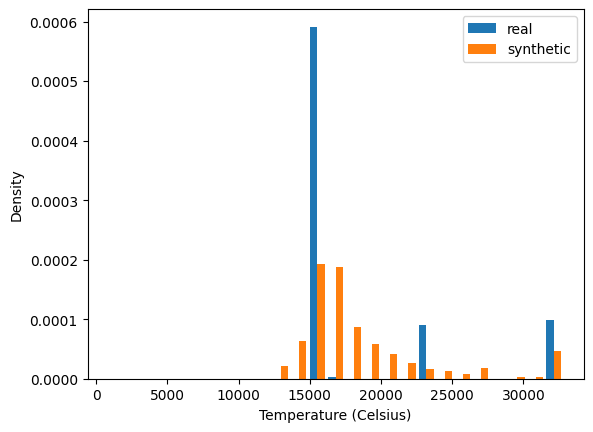

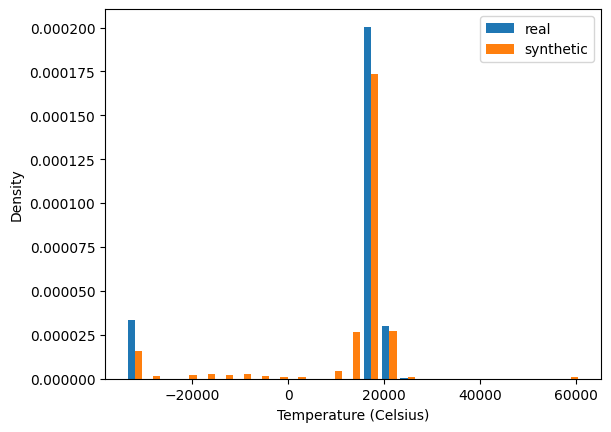

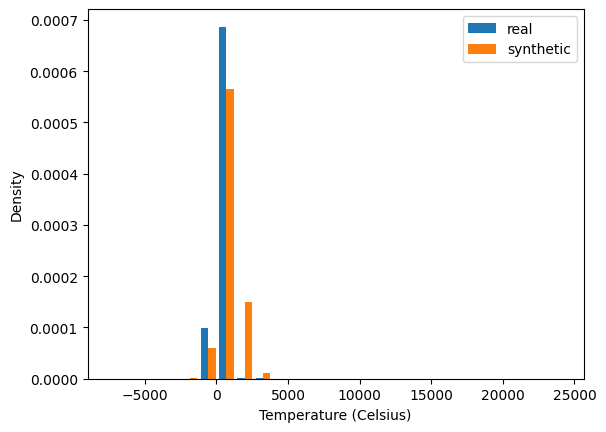

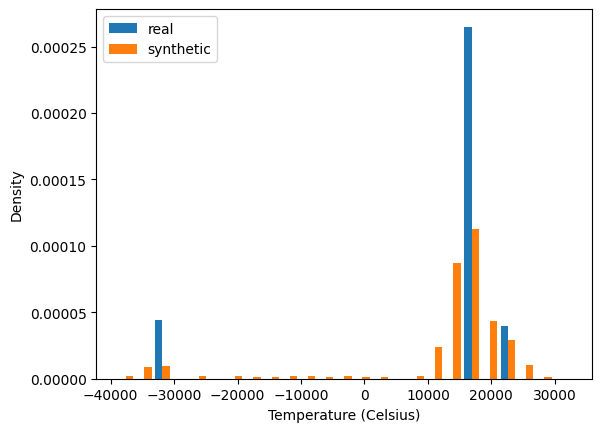

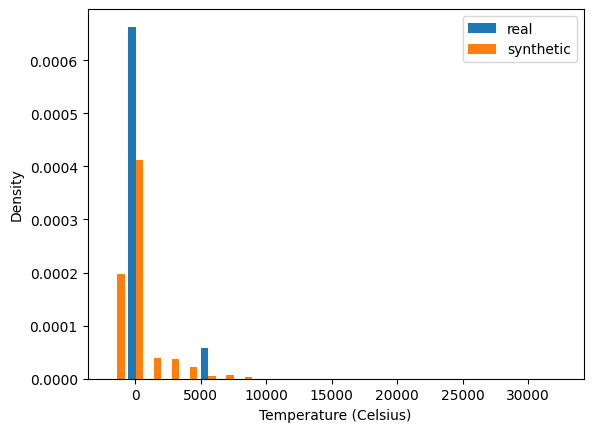

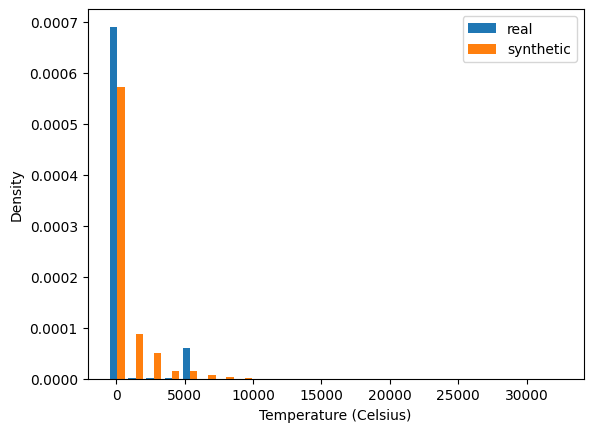

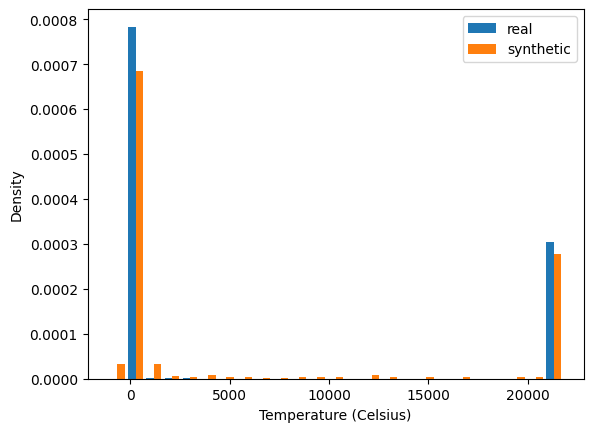

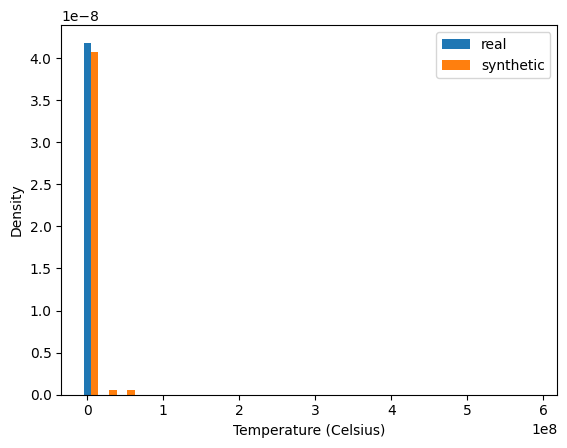

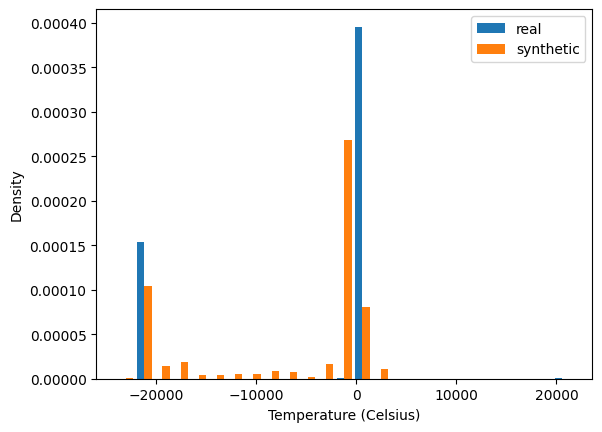

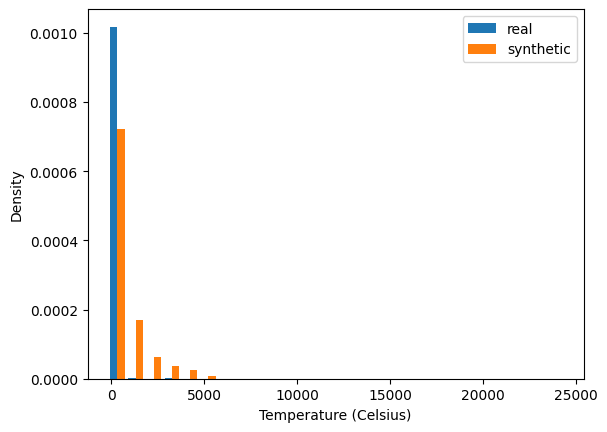

In [72]:
# Compare distribution of T_out values
for i in range(synthetic_features.shape[-1]):
    plt.hist([final[:,:,i].flatten(), synthetic_features[:,:,i].flatten()], 
             label=["real", "synthetic"],
             bins=25,
             density=True)
    plt.legend()
    plt.xlabel("Temperature (Celsius)")
    plt.ylabel("Density")
    plt.show()
# plt.hist([final[:,:,2].flatten(), synthetic_features[:,:,2].flatten()], 
#          label=["real", "synthetic"],
#          bins=25,
#          density=True)
# plt.legend()
# plt.xlabel("Temperature (Celsius)")
# plt.ylabel("Density")
# plt.show()

# Temperature distribution for T_out is similar

In [ ]:
from scipy.fft import fft

# 计算频谱
real_fft = np.abs(fft(real_data[0, :, 0]))
synthetic_fft = np.abs(fft(synthetic_data[0, :, 0]))

plt.figure(figsize=(12, 6))
plt.plot(real_fft, label='真实数据的频谱')
plt.plot(synthetic_fft, label='合成数据的频谱')
plt.legend()
plt.title('频谱比较')
plt.show()


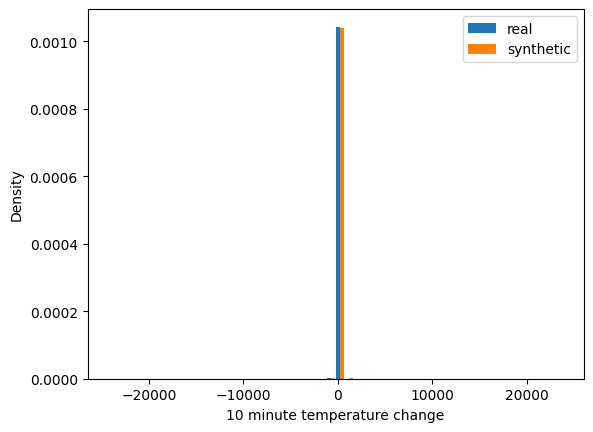

In [47]:
# Compare distribution of 1-step (10 minute) diffs for T_out
real_diffs = np.diff(final, axis=1)
synthetic_diffs = np.diff(synthetic_features, axis=1)

plt.hist([real_diffs[:,:,2].flatten(), synthetic_diffs[:,:,2].flatten()],
         label=["real", "synthetic"],
         bins=50,
         density=True)
plt.legend()
plt.xlabel("10 minute temperature change")
plt.ylabel("Density")
plt.show()

# 1-step diffs for synthetic data have higher variance, this aligns with the
# increased noise visible in the plots

In [91]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# 假设 synthetic_features 是你生成的合成数据
synthetic_features = np.array([
    [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]],
    [[21, 22, 23, 24, 25, 26, 27, 28, 29, 30], [31, 32, 33, 34, 35, 36, 37, 38, 39, 40]],
    [[41, 42, 43, 44, 45, 46, 47, 48, 49, 50], [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]],
    [[61, 62, 63, 64, 65, 66, 67, 68, 69, 70], [71, 72, 73, 74, 75, 76, 77, 78, 79, 80]],
    [[81, 82, 83, 84, 85, 86, 87, 88, 89, 90], [91, 92, 93, 94, 95, 96, 97, 98, 99, 100]]
])

# 获取当前时间
current_time = datetime.now()

# 生成时间戳列表，每个批次的时间戳相差一小时
timestamps = [current_time + timedelta(hours=i) for i in range(synthetic_features.shape[0])]

# 为每个批次添加时间戳
# 扩展时间戳的形状，使其与 synthetic_features 匹配
timestamp_array = np.array(timestamps).reshape(-1, 1, 1)
timestamp_array = np.tile(timestamp_array, (1, synthetic_features.shape[1], 1))

# 合并时间戳和特征数据
synthetic_features_with_timestamps = np.concatenate((timestamp_array, synthetic_features), axis=2)

# 将三维数组转换为二维数据框
reshaped_features = synthetic_features_with_timestamps.reshape(-1, synthetic_features_with_timestamps.shape[2])

# 假设原始数据框的列名如下
columns = ['Time', 'Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7', 'Feature8', 'Feature9', 'Feature10']

# 创建数据框
synthetic_df = pd.DataFrame(reshaped_features, columns=columns)

# 打印数据框
print(synthetic_df)


                        Time Feature1 Feature2 Feature3 Feature4 Feature5  \
0 2024-06-24 18:42:04.600952        1        2        3        4        5   
1 2024-06-24 18:42:04.600952       11       12       13       14       15   
2 2024-06-24 19:42:04.600952       21       22       23       24       25   
3 2024-06-24 19:42:04.600952       31       32       33       34       35   
4 2024-06-24 20:42:04.600952       41       42       43       44       45   
5 2024-06-24 20:42:04.600952       51       52       53       54       55   
6 2024-06-24 21:42:04.600952       61       62       63       64       65   
7 2024-06-24 21:42:04.600952       71       72       73       74       75   
8 2024-06-24 22:42:04.600952       81       82       83       84       85   
9 2024-06-24 22:42:04.600952       91       92       93       94       95   

  Feature6 Feature7 Feature8 Feature9 Feature10  
0        6        7        8        9        10  
1       16       17       18       19        20  
2 

In [6]:
import pickle
import pandas as pd
import numpy as np
# Load the synthetic data
with open('synthetic_data_2000_axis1.pkl', 'rb') as f:
    synthetic_features = pickle.load(f)


In [7]:
synthetic_features.shape

(300, 2000, 10)

['Effektivwert_z',
 'Median_z',
 'Mittlere_Absolute_Abweichung_z',
 'Mittelwert_z',
 'Median_y',
 'Effektivwert_y',
 'Effektivwert_x',
 'Variance_z',
 'Mittelwert_x',
 'Standardabweichung_z']

In [13]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta


# 获取当前时间
current_time = datetime.now()

# 生成UNIX时间戳列表，每个批次的时间戳相差一小时
timestamps = [(current_time + timedelta(hours=i)).timestamp() for i in range(synthetic_features.shape[0])]
len(timestamps)
timestamp_array = np.array(timestamps).reshape(-1, 1, 1)
timestamp_array.shape
timestamp_array = np.tile(timestamp_array, (1, synthetic_features.shape[1], 1))


In [24]:
timestamp_array[0,:,:]	

array([[1.72147603e+09],
       [1.72147603e+09],
       [1.72147603e+09],
       ...,
       [1.72147603e+09],
       [1.72147603e+09],
       [1.72147603e+09]])

 # axis1 2000 features["Effektivwert_z","Median_z", "Mittlere_Absolute_Abweichung_z", "Mittelwert_z", "Median_y", "Effektivwert_y", "Effektivwert_x", "Variance_z", "Mittelwert_x", "Standardabweichung_z"]

In [27]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import json 
import pickle
import pandas as pd
import numpy as np
# Load the synthetic data
with open('synthetic_data_2000_axis1.pkl', 'rb') as f:
    synthetic_features = pickle.load(f)
print(synthetic_features.shape)
with open ('feature_important_axis1.json', 'r') as f:
    importance = json.load(f)
print(importance)
# 获取当前时间
current_time = datetime.now()

# 生成UNIX时间戳列表，每个批次的时间戳相差一小时
timestamps = [(current_time + timedelta(hours=i)).timestamp() for i in range(synthetic_features.shape[0])]

# 为每个批次添加UNIX时间戳
# 扩展时间戳的形状，使其与 synthetic_features 匹配
timestamp_array = np.array(timestamps).reshape(-1, 1, 1)
timestamp_array = np.tile(timestamp_array, (1, synthetic_features.shape[1], 1))

# 合并时间戳和特征数据
synthetic_features_with_timestamps = np.concatenate((timestamp_array, synthetic_features), axis=2)

# 将三维数组转换为二维数据框
reshaped_features = synthetic_features_with_timestamps.reshape(-1, synthetic_features_with_timestamps.shape[2])
# 假设原始数据框的列名如下
columns =['Timestamp']+ importance

# 创建数据框
synthetic_df = pd.DataFrame(reshaped_features, columns=columns)

# 打印数据框
print(synthetic_df)
synthetic_df.to_csv('synthetic_data_2000_axis1.csv', index=False)

(300, 2000, 10)
['Effektivwert_z', 'Median_z', 'Mittlere_Absolute_Abweichung_z', 'Mittelwert_z', 'Median_y', 'Effektivwert_y', 'Effektivwert_x', 'Variance_z', 'Mittelwert_x', 'Standardabweichung_z']
           Timestamp  Effektivwert_z      Median_z  \
0       1.721476e+09    16583.060547  14809.136719   
1       1.721476e+09    16582.994141  14808.652344   
2       1.721476e+09    16582.958984  14809.625000   
3       1.721476e+09    16582.958984  14809.375000   
4       1.721476e+09    16582.943359  14809.921875   
...              ...             ...           ...   
599995  1.722553e+09    13483.210938  16318.375000   
599996  1.722553e+09    13480.842773  16319.394531   
599997  1.722553e+09    13478.639648  16322.644531   
599998  1.722553e+09    13479.916992  16320.660156   
599999  1.722553e+09    13479.846680  16320.769531   

        Mittlere_Absolute_Abweichung_z  Mittelwert_z    Median_y  \
0                           112.215935  14589.859375  -40.987061   
1               

In [28]:
synthetic_df.head()

,Timestamp,Effektivwert_z,Median_z,Mittlere_Absolute_Abweichung_z,Mittelwert_z,Median_y,Effektivwert_y,Effektivwert_x,Variance_z,Mittelwert_x,Standardabweichung_z
0,1.721476e+09,16583.060547,14809.136719,112.215935,14589.859375,-40.987061,742.481018,21747.822266,-61223.265625,-21511.958984,1756.340210
1,1.721476e+09,16582.994141,14808.652344,111.610374,14589.828125,-40.915283,737.515747,21747.626953,-69958.359375,-21510.826172,1756.326050
2,1.721476e+09,16582.958984,14809.625000,111.903946,14589.925781,-40.892090,740.172607,21747.787109,-69023.914062,-21513.232422,1756.357910
3,1.721476e+09,16582.958984,14809.375000,111.996399,14590.082031,-40.965332,741.036560,21747.757812,-68024.179688,-21512.185547,1756.419678
4,1.721476e+09,16582.943359,14809.921875,112.016266,14589.929688,-41.034424,740.325623,21747.820312,-65462.996094,-21512.496094,1756.278687


# axis1 10000 features["Effektivwert_z","Median_z", "Mittlere_Absolute_Abweichung_z", "Mittelwert_z", "Median_y", "Effektivwert_y", "Effektivwert_x", "Variance_z", "Mittelwert_x", "Standardabweichung_z"]

In [29]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import json 
import pickle
import pandas as pd
import numpy as np
# Load the synthetic data
with open('synthetic_data_10000_axis1.pkl', 'rb') as f:
    synthetic_features = pickle.load(f)
print(synthetic_features.shape)
with open ('feature_important_axis1.json', 'r') as f:
    importance = json.load(f)
print(importance)
# 获取当前时间
current_time = datetime.now()

# 生成UNIX时间戳列表，每个批次的时间戳相差一小时
timestamps = [(current_time + timedelta(hours=i)).timestamp() for i in range(synthetic_features.shape[0])]

# 为每个批次添加UNIX时间戳
# 扩展时间戳的形状，使其与 synthetic_features 匹配
timestamp_array = np.array(timestamps).reshape(-1, 1, 1)
timestamp_array = np.tile(timestamp_array, (1, synthetic_features.shape[1], 1))

# 合并时间戳和特征数据
synthetic_features_with_timestamps = np.concatenate((timestamp_array, synthetic_features), axis=2)

# 将三维数组转换为二维数据框
reshaped_features = synthetic_features_with_timestamps.reshape(-1, synthetic_features_with_timestamps.shape[2])
# 假设原始数据框的列名如下
columns =['Timestamp']+ importance

# 创建数据框
synthetic_df = pd.DataFrame(reshaped_features, columns=columns)

# 打印数据框
print(synthetic_df)
synthetic_df.to_csv('synthetic_data_10000_axis1.csv', index=False)

(50, 10000, 10)
['Effektivwert_z', 'Median_z', 'Mittlere_Absolute_Abweichung_z', 'Mittelwert_z', 'Median_y', 'Effektivwert_y', 'Effektivwert_x', 'Variance_z', 'Mittelwert_x', 'Standardabweichung_z']
           Timestamp  Effektivwert_z      Median_z  \
0       1.721477e+09    13939.009766  21030.402344   
1       1.721477e+09    13862.076172  21020.027344   
2       1.721477e+09    13894.307617  21022.558594   
3       1.721477e+09    13878.738281  21337.906250   
4       1.721477e+09    13915.550781  21118.734375   
...              ...             ...           ...   
499995  1.721653e+09    21858.548828   4632.273438   
499996  1.721653e+09    21860.375000   4580.570312   
499997  1.721653e+09    21834.052734   4578.906250   
499998  1.721653e+09    21882.958984   4475.980469   
499999  1.721653e+09    21877.109375   4556.238281   

        Mittlere_Absolute_Abweichung_z  Mittelwert_z     Median_y  \
0                          1308.211670  17277.109375  1010.787109   
1             

In [30]:
synthetic_df.head()

,Timestamp,Effektivwert_z,Median_z,Mittlere_Absolute_Abweichung_z,Mittelwert_z,Median_y,Effektivwert_y,Effektivwert_x,Variance_z,Mittelwert_x,Standardabweichung_z
0,1.721477e+09,13939.009766,21030.402344,1308.211670,17277.109375,1010.787109,1276.927734,20346.619141,12328100.0,-16969.375000,886.312500
1,1.721477e+09,13862.076172,21020.027344,1321.467651,17220.421875,907.935303,1219.153564,20392.701172,13458755.0,-16939.951172,923.019409
2,1.721477e+09,13894.307617,21022.558594,1285.380859,17250.023438,1010.308350,1301.046997,20378.734375,13134255.0,-16945.289062,945.231873
3,1.721477e+09,13878.738281,21337.906250,1313.531128,17277.574219,1080.265869,1211.750610,20349.361328,12526677.0,-16908.394531,868.712158
4,1.721477e+09,13915.550781,21118.734375,1325.578247,17304.449219,1199.155273,1410.306274,20381.224609,13421669.0,-16913.527344,850.431152


In [39]:
import pickle
with open('synthetic_data_2000_axis1.pkl', 'rb') as f:
    synthetic_features = pickle.load(f)
print(synthetic_features.shape)

(300, 2000, 10)
